# Alternating Least Squares with Weighted Regularization

In [1]:
import os

import numpy as np
import pandas as pd
from subprocess import call
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline


In [6]:
# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

## MovieLens Dataset

In [2]:
file_dir = 'ml-100k'
file_path = os.path.join(file_dir, 'u.data')

if not os.path.isdir(file_dir):
    call(['curl', '-O', 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'])
    call(['unzip', 'ml-100k.zip'])
    
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv(file_path, sep = '\t', names=names)
print(df.shape)
df.head()

(100000, 4)


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


As we can see, the only data that we have is how each user interacted or rated each item.   
Given this information, collaborative filtering will start by constructing a user-item matrix with each distinct user being the row, item being the column and the value for each cell will simply be the rating that the user gave to the item.   
Apart from building the matrix, we will also print out some other information to help us understand our data a bit better.

In [5]:
# create the rating matrix r_{ui}
# remember to subtract the user and item id by 1 since the indices starts from 0
n_users = df['user_id'].unique().shape[0]
n_items = df['item_id'].unique().shape[0]
# initialize
ratings = np.zeros((n_users, n_items))
for row in df.itertuples(index=False): # iterrowよりも高速
    ratings[row.user_id-1, row.item_id-1] = row.rating

# compute the no-zero elements in the rating matrix
matrix_size = np.prod(ratings.shape)
interaction = np.flatnonzero(ratings).shape[0] # retrun "indices" tha are non-zero
sparsity = (interaction/matrix_size) * 100

print('dimensition: ', ratings.shape)
print('sparsity: {:.1f}%'.format(sparsity))
ratings

dimensition:  (943, 1682)
sparsity: 6.3%


array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

From the information above, we know there are 943 unique users, 1682 unique items.   
Within the rating matrix, only 6.3% of the cells have a value, although we filled in empty ratings as 0, we should **not** assume these values to truly be zero.   
More appropriately, they are just missing entries. This kind of sparsity is extremely common in recommendation system, where people seldom give ratings to things that they have purchased.   
One thing to note is that if the sparsity of the matrix is **below 1% (rule of thumb), then the dataset might be too sparse to perform any sort of modeling**.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


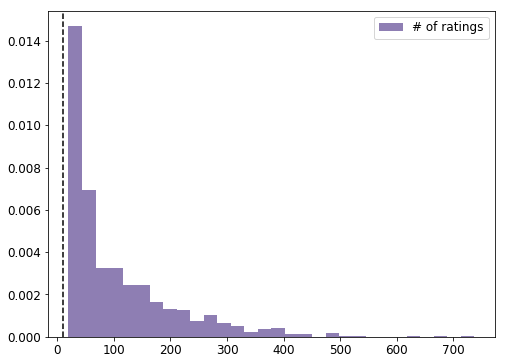

In [9]:
plt.hist(np.sum(ratings != 0, axis=1), histtype='stepfilled', bins=30,
            alpha=0.85, label='# of ratings', color='#7A68A6', normed=True)
plt.axvline(x = 10, color='black', linestyle='--')
plt.legend(loc = "upper right")
plt.show()

Next the histogram tells us that every user has given at least more than 10 ratings, we will use this to perform the train/test split of the data for testing the algorithm that we'll build later.

One tricky thing about splitting the data into training and testing is that:   
In supervise machine learning we normally build the trainining and testing holdout set by randomly splitting the rows. In those cases, this idea works, because we have a model with features/target that we are trying to fit a function to.   

For recommender systems with collaborative filtering (no features), this just **won't work** anymore, because all of the items/users need to be available when the model is first built. So what we do instead is **mask a random sample of the user/item ratings** to validate and compare how well the recommender system did in predicting the ratings of those masked values. In our case, given **we already know each user has given more than 10 ratings**, what we'll do is for every user, we **remove 10 of the item ratings and and assign them to the test set**. The testing matrix is printed below, as hopefully, you can see that some of the values are indeed different from the original rating matrix.

In [10]:
def create_train_test(ratings):
    """
    split into training and test sets,
    remove 10 ratings from each user
    and assign them to the test set
    """
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_index = np.random.choice(np.flatnonzero(ratings[user]), size=10, replace=False)
        
        train[user, test_index] = 0.0 # 学習データからは削除
        test[user, test_index] = ratings[user, test_index]
        
    # assert that training and testing set are truly disjoint
    # trainとtestの同じ位置の各要素の積をとり，全て０となるかをチェック
    # testはtrainのうち各ユーザ１０個ずつテストデータをとり，trainはその要素を0とする
    assert np.all(train * test == 0)
    return train, test

In [11]:
train, test = create_train_test(ratings)
del ratings # save memory
train

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

## Matrix Factorization with ALS

Recall that we had a user-item matrix,  $R$  where nonzero elements of the matrix are ratings that a user has given an item.  
What Matrix Factorization does is it decomposes a large matrix into products of matrices, namely,  $R=U×V$.

Matrix factorization assumes that:
- Each user can be described by  $d$  features. For example, feature 1 might be a referring to how much each user likes disney movies.
- Each item, movie in this case, can be described by an analogous set of  $d$  features. To correspond to the above example, feature 1 for the movie might be a number that says how close the movie is to a disney movie.

The cool thing about this is that, we do not know what these features are nor do we have to determine them beforehand, which is why these features are often refer to as latent features.   
Next, we also don't know how many latent features are optimal for the task at hand.   
Thus, we can use random search or grid search or other fancy techniques to perform hyperparameter tuning and determine the best number for  $d$ .

Given all those information, the next question is: how do we learn the user matrix,  $U$ , and item matrix,  $V$ ?  
Well, like a lot of machine learning algorithm, by minimizing a loss function.

We start by denoting our  d  feature user into math by letting a user  u  take the form of a  1×$d$ -dimensional vector  $x_u$ . These for often times referred to as latent vectors or low-dimensional embeddings.  
Similarly, an item $i$ can be represented by a  1×$d$ -dimensional vector  $y_i$ . And the rating that we predict user $u$ will give for item $i$ is just the dot product of the two vectors

$$\hat r_{ui} = \vec{x_u} \vec{y_i}^T = \sum_d x_{ud}y_{di}$$

Where  $\hat r_{ui}$  represents our prediction for the true rating  $r_{ui}$ .

Next, we will choose a objective function to minimize the square of the difference between all ratings in our dataset ($S$) and our predictions. This produces a objective function of the form:

$$L = \sum_{u,i\in{S}}(\vec{r_{ui}} - \vec{x_u} \vec{y_i}^T)^2 + \lambda(\sum_u|\vec{x_u}|^2 + \sum_i|\vec{y_i}|^2)$$

Note that we've added on two  $L_2$  regularization terms, with $λ$ controlling the strength at the end to prevent overfitting of the user and item vectors.  
$λ$, is another hyperparameter that we'll have to search for to determine the best value. 

Now that we formalize our objective function, we'll introduce the **Alternating Least Squares with Weighted Regularization (ALS-WR)** method for optimizing it.  
The way it works is we start by treating one set of latent vectors as constant. For this example, we'll pick the item vectors, $y_i$ . We then take the derivative of the loss function with respect to the other set of vectors, the user vectors,  $x_u$ and solve for the non-constant vectors (the user vectors).

$$\frac{\partial L}{\partial \vec{x_u}} = -2\sum_{i}(\vec{r_{ui}} - \vec{x_u} \vec{y_i}^T)\vec{y_i} + 2\lambda\vec{x_u} = 0$$
$$= -(\vec{r_u}-\vec{x_u}Y^T)Y + \lambda\vec{x_u} = 0$$
$$= \vec{x_u}(Y^TY+\lambda I) = \vec{r_u}Y$$
$$= \vec{x_u} =  \vec{r_u}Y(Y^TY+\lambda I)^{-1}$$

- The row vector $r_u$ represents users $u$'s row from the ratings matrix with all the ratings for all the items (so it has dimension  1×$n$ )  
- We introduce the symbol $Y$, with dimensions $n×d$ , to represent all item row vectors vertically stacked on each other
- Lastly, $I$ is the identity matrix which has dimension $d×d$ to ensure the matrix multiplication's dimensionality will be correct when we add the $λ$

Now comes the alternating part: With these newly updated user vectors in hand, in the next round, we hold them as constant, and take the derivative of the loss function with respect to the previously constant vectors (the item vectors). 

$$\frac{\partial L}{\partial \vec{y_i}} = \vec{y_i} =  \vec{r_i}X(X^TX+\lambda I)^{-1}$$

Then we alternate back and forth and carry out this two-step process until convergence.  
The reason we alternate is, optimizing user latent vectors, $U$, and item latent vectors $V$ simultaneously is hard to solve (**NP hardness**).  
If we fix $U$ or $V$ and tackle one problem at a time, we potentially turn it into a easier sub-problem. Just to summarize it, ALS works by:
- Initialize the user latent vectors, $U$, and item latent vectors $V$ with **randomly**
- Fix $U$ and solve for $V$
- Fix $V$ and solve for  $U$
- Repeat step 2 and 3 until convergence

Now that we have our equations, let's program this thing up!  
We'll set the model to use **20 factors** and a **regularization value of 0.01 (chosen at random)** and train it for **100 iterations** and compute the **mean square error** on the train and test set to assess algorithm convergence.

In [18]:
class ExplicitMF():
    """
    Train a matrix factorization mode using Alternating Least Squares to predict empty entries in a matrix
    
    Parameters
    ----------------
    n_iters : int
        number of iterations to train the algoritm
        
    n_factors : int
        number of latent factors to use in matrix
        factorization model, some machine-learning libraries denote this as 'rank'
        
    reg : float
        regularization term for item/user latent factors, since lambda is a keyword in python we use reg instead
    """
    
    def __init__(self, n_iters, n_factors, reg):
        self.reg = reg
        self.n_iters = n_iters
        self.n_factors = n_factors
        
    def fit(self, train, test):
        """
        pass in training and testing at the same time to record model convergence,
        assuming both dataset is in the form of User x Item matrix with cells as ratings
        """
        self.n_user, self.n_item = train.shape
        self.user_factors = np.random.random((self.n_user, self.n_factors))
        self.item_factors = np.random.random((self.n_item, self.n_factors))
        
        # record the training and testing mse for every iteration to show convergence later (usually, not worth it for production)
        self.test_mse_record = []
        self.train_mse_record = []
        for it in range(self.n_iters):
            self.user_factors = self._als_step(train, self.user_factors, self.item_factors)
            self.item_factors = self._als_step(train.T, self.item_factors, self.user_factors)
            predictions = self.predict()
            test_mse = self.compute_mse(test, predictions)
            train_mse = self.compute_mse(train, predictions)
            self.test_mse_record.append(test_mse)
            self.train_mse_record.append(train_mse)
            print('iter: {}, test_mse: {}, train_mse: {}'.format(it+1, test_mse, train_mse))
            
        return self
            
            
    def _als_step(self, ratings, solve_vecs, fixed_vecs):
        """
        when updating the user matrix, the item matrix is the fixed vector and vice varsa
        """
        A = fixed_vecs.T.dot(fixed_vecs) + np.eye(self.n_factors) * self.reg
        b = ratings.dot(fixed_vecs)
        A_inv = np.linalg.inv(A)
        solve_vecs = b.dot(A_inv)
        return solve_vecs
    
    
    def predict(self):
        """
        predict ratings for every user and item
        """
        pred = self.user_factors.dot(self.item_factors.T)
        return pred
    
    
    @staticmethod
    def compute_mse(y_true, y_pred):
        """
        ignore zero terms prior to comparing the mse
        """
        mask = np.nonzero(y_true)
        mse = mean_squared_error(y_true[mask], y_pred[mask])
        return mse

In [16]:
def plot_learning_curve(model):
    """
    visualize the training/testing loss
    """
    linewidth = 3
    plt.plot(model.test_mse_record, label='Test', linewidth=linewidth)
    plt.plot(model.train_mse_record, label='Train', linewidth=linewidth)
    plt.xlabel('iterations')
    plt.ylabel('MSE')
    plt.legend(loc='best')

iter: 1, test_mse: 9.66617032872331, train_mse: 5.371658662257342
iter: 2, test_mse: 8.532033989615, train_mse: 4.208043738335672
iter: 3, test_mse: 8.464862082924245, train_mse: 4.060217804495945
iter: 4, test_mse: 8.445007728166754, train_mse: 4.0084207943468035
iter: 5, test_mse: 8.436663691719303, train_mse: 3.983698810608167
iter: 6, test_mse: 8.433352368390384, train_mse: 3.969927961726057
iter: 7, test_mse: 8.431965433236424, train_mse: 3.9614800575923605
iter: 8, test_mse: 8.431139155110195, train_mse: 3.955984638937514
iter: 9, test_mse: 8.430415319400526, train_mse: 3.9522640158992615
iter: 10, test_mse: 8.429718782271141, train_mse: 3.9496585532232307
iter: 11, test_mse: 8.429087142364219, train_mse: 3.9477743174636224
iter: 12, test_mse: 8.42856212679794, train_mse: 3.946367764683358
iter: 13, test_mse: 8.42816162810192, train_mse: 3.94528447352447
iter: 14, test_mse: 8.427881936017737, train_mse: 3.9444242684847985
iter: 15, test_mse: 8.427706862451844, train_mse: 3.943720

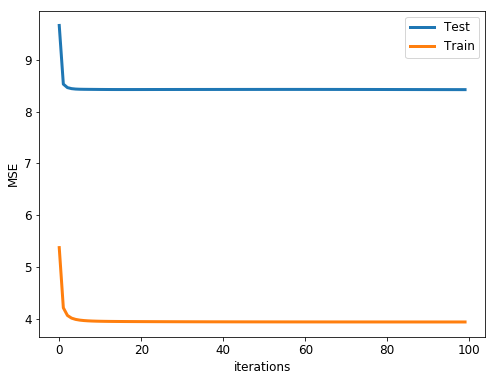

In [17]:
als = ExplicitMF(n_iters=100, n_factors=40, reg=0.01)
als.fit(train, test)
plot_learning_curve(als)

Notice that ALS converges after **a few** sweeps, which is one of the main reason for its popularity.  
**Fast**, thus **scalable** to bigger dataset.